In [23]:
import math
from copy import deepcopy
import numpy as np
import types
import pylab
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly.graph_objs import Surface
import plotly.tools as tls
tls.set_credentials_file(username='Mungos', api_key='mcnflyescl')

## Helper functions

In [24]:
def is_numeric(x):
    NumberTypes = (types.IntType, types.LongType, types.FloatType)
    return isinstance(x, NumberTypes)

class Function:
    def __init__(self, func=None):
        if func:
            self.calls = 0
            self.function = func

    def evaluate(self,X):
        self.calls+=1
        return self.function(X)

## Funkcije

In [25]:
def f_test(x):
    if is_numeric(x):
        return (x-4)**2
    elif len(x) == 1:
        return (x[0]-4)**2
    else:
        raise Exception("Argument passed needs to be a list with 1 element or a numeric type")
    
def f1(x):
    if len(x) != 2:
        raise Exception("Argument needs to be a list with two elements")
    return 100*(x[1]-x[0]**2)**2 + (1-x[0])**2

def f2(x):
    if len(x) != 2:
        raise Exception("Argument needs to be a list with two elements")
    return (x[0]-4.)**2 + 4.*(x[1]-2)**2

def f3(x):
    el_sum = 0
    for i, element in enumerate(x):
        el_sum+=(element-i-1)**2
    return el_sum

def f4(x):
    if len(x) != 2:
        raise Exception("Argument needs to be a list with two elements")
    return abs((x[0]-x[1])*(x[0]*x[1]))+ math.sqrt(x[0]**2+x[1]**2)

def f6(x):
    el_sum = 0
    for el in x:
        el_sum += el**2
    return 0.5 +(math.sin(math.sqrt(el_sum)-0.5))/(1+0.001*el_sum)

## Unimodal interval

In [26]:
def find_unimodal(starting_point, function, starting_step=1):
    step = starting_step
    current_point = starting_point
    direction = 1
    if function(current_point + step) >= function(current_point):
        direction=-1
    next_point = current_point + direction*step
    cnt = 1
    previous_point = current_point
    while function(current_point) > function(next_point):
        previous_point = current_point
        current_point = next_point
        next_point = starting_point + direction * (2**cnt) * step
        cnt+=1
    
    if previous_point > next_point:
        return next_point, previous_point
    return previous_point, next_point

## Golden section search

In [27]:
def golden_section_search(f,starting_point = None, a=None,b=None,eps=1, verbose = False):
    if starting_point != None:
        a,b = find_unimodal(starting_point,f.evaluate,eps)
    elif a==None or b== None:
        raise Exception("Starting point or unimodal interval needs to be given")
    
    if verbose:
        print "Searching in interval [%f, %f]" % (a,b)
    
    
    fi = (math.sqrt(5.0) - 1.0)/2
    c = b - (b - a)*fi
    d = a + (b - a)*fi
    while (b - a) > eps:
        c_score, d_score = f.evaluate(c),f.evaluate(d)
        if verbose:
            print "|a = %.3f|c = %.3f|d = %.3f|b = %.3f|f(c) = %.3f|f(d) = %.3f|f(c) > f(d) = %s" %(a,c,d,b,c_score,d_score, c_score>d_score)
        if c_score >= d_score:
            a = c
            c = d
            d = a + (b - a)*fi
        else:
            b = d
            d = c
            c = b - (b - a)*fi
    if verbose:
        print ''
        print "Final interval = [",a,", ", b,"]"
    return (a+b)/2.

## Coordinate descend

In [28]:
def coordinate_search(function,starting_point, epsilon_vector = None ):
    if epsilon_vector==None:
        epsilon_vector = [1e-6]*len(starting_point)
        
    coordinate_changed = [False]*len(starting_point)
    min_point = deepcopy(starting_point)
    reset_flag = lambda x: False
    
    cnt = 10
    while any(flag == False for flag in coordinate_changed):
        coordinate_changed = map(reset_flag, coordinate_changed)
        
        def function_1D_wrapper(function,index, array):
            cpy = deepcopy(array)
            class Decorator:
                def __init__(self,cpy,index,function):
                    self.index = index
                    self.cpy = cpy
                    self.function = function
                    
                def evaluate(self,x):
                    self.cpy[self.index] = x
                    return self.function.evaluate(cpy)
            return Decorator(cpy,index,function)
        
        for i,coord in enumerate(min_point):
            func_1D = function_1D_wrapper(function, i, min_point)
            new_coord = golden_section_search(func_1D, coord, eps = epsilon_vector[i])
            min_point[i] = new_coord
            #print new_coord
            if abs(coord-new_coord)<= epsilon_vector[i]:
                coordinate_changed[i] = True
        cnt-=1
        if cnt<0:
            break
    return min_point

# Nelder i Mead simpleks

In [29]:
def nelder_mead(f, x_start,
                step=1, no_improve_thr=10e-6,
                no_improv_break=50, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5,verbose=False):
    
    dim = len(x_start)
    prev_best = f.evaluate(x_start)
    no_improv = 0
    x_start = np.array(x_start).astype(np.float64)
    res = [[x_start, prev_best]]

    for i in range(dim):
        x = deepcopy(x_start)
        x[i] = x[i] + step
        score = f.evaluate(x)
        res.append([x, score])
    
    
    # simplex iter
    iters = 0
    while 1:
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]

        # break after max_iter
        if max_iter and iters >= max_iter:
            return res[0][0]
        iters += 1

        # break after no_improv_break iterations with no improvement
        if verbose:
            print 'best so far:', best

        if best < prev_best - no_improve_thr:
            no_improv = 0
            prev_best = best
        else:
            no_improv += 1

        if no_improv >= no_improv_break:
            return res[0][0]

        # centroid
        x0 = [0.] * dim
        for tup in res[:-1]:
            for i, c in enumerate(tup[0]):
                x0[i] += c / (len(res)-1)
                
        # reflection
        xr = x0 + alpha*(x0 - res[-1][0])
        rscore = f.evaluate(xr)
        if rscore < res[0][1]:
            xe = x0 + gamma*(x0 - res[-1][0])
            escore = f.evaluate(xe)
            if escore < res[0][1]:
                del res[-1]
                res.append([xe, escore])
                continue
            else:
                del res[-1]
                res.append([xr, rscore])
                continue
        else:
            if rscore > res[-2][1]:
                if rscore < res[-1][1]:
                    del res[-1]
                    res.append([xr, rscore])
                # contraction
                xc = x0 + rho*(x0 - res[-1][0])
                cscore = f.evaluate(xc)
                if cscore < res[-1][1]:
                    del res[-1]
                    res.append([xc, cscore])
                    continue
                else:
                    # reduction
                    x1 = res[0][0]
                    nres = []
                    for tup in res:
                        redx = x1 + sigma*(tup[0] - x1)
                        score = f.evaluate(redx)
                        nres.append([redx, score])
                    res = nres
            else:
                del res[-1]
                res.append([xr, rscore])


if __name__ == "__main__":
    
    fun = Function(f4)
    print nelder_mead(fun, [5,5],verbose=True)

best so far: 7.07106781187
best so far: 7.07106781187
best so far: 7.07106781187
best so far: 7.07106781187
best so far: 7.07106781187
best so far: 7.07106781187
best so far: 7.07106781187
best so far: 7.07106781187
best so far: 7.07106781187
best so far: 7.07106781187
best so far: 7.07106781187
best so far: 7.07106781187
best so far: 6.82312616626
best so far: 6.82312616626
best so far: 6.60919301696
best so far: 6.11519561699
best so far: 5.19963541719
best so far: 3.90053460744
best so far: 0.841601866643
best so far: 0.252998434636
best so far: 0.252998434636
best so far: 0.252998434636
best so far: 0.207010436257
best so far: 0.207010436257
best so far: 0.123682146637
best so far: 0.0610832964559
best so far: 0.0603777393962
best so far: 0.0536095407197
best so far: 0.0502312404999
best so far: 0.0390921228821
best so far: 0.0364226466503
best so far: 0.0364226466503
best so far: 0.0364226466503
best so far: 0.0323375356159
best so far: 0.0287163454128
best so far: 0.019008166731


# Hooke-Jeeves

In [30]:
def hooke_jeeves(function,starting_point,search_direction=None,decay_coeff=0.7,epsilon=None,max_iter = 0, max_patience = 30, verbose=False):
    
    if search_direction == None:
        search_direction = [0.5] * len(starting_point)
        
    if epsilon == None:
        epsilon = np.array([1e-6]*len(starting_point))
    else:
        epsilon = np.array(epsilon)
        
    iters = 0
    patience = 0
    same_threshold = 1e-9
    dX = np.array(search_direction).astype(np.float64)
    search_point = deepcopy(np.array(starting_point).astype(np.float64))
    base_point = deepcopy(np.array(starting_point).astype(np.float64))
    base_point_score = function.evaluate(base_point)
    while True:
        if verbose:
            print "Iteration %s base_point = %s" % (iters, base_point)
        if max_iter!=0 and iters >= max_iter:
            return base_point
        
        new_point = istrazi(search_point, function, dX)
        new_point_score = function.evaluate(new_point)
        if abs(new_point_score-base_point_score) > same_threshold and new_point_score<base_point_score:
            search_point = (2. * new_point) - base_point
            base_point = deepcopy(new_point)
            base_point_score = function.evaluate(base_point)
        else:
            dX *=decay_coeff
            search_point = deepcopy(base_point)
            if (abs(base_point-new_point)<epsilon).all(False):
                if patience > max_patience:
                    return base_point
                else:
                    patience +=1
        if iters > 200:
            break
        iters+=1
        

def istrazi(point,fun, search_direction):
    x = deepcopy(point)
    dim = len(x)
    for i in range(dim):
        temp = fun.evaluate(x)
        x[i]+=search_direction[i]
        new = fun.evaluate(x)
        if new > temp:
            x[i]-=search_direction[i]*2
            new = fun.evaluate(x)
            if new > temp:
                x[i] = x[i] + search_direction[i]
    return x

fun = Function(f4)
print hooke_jeeves(fun,[5.1,1.1],[1,1], verbose=True)

Iteration 0 base_point = [ 5.1  1.1]
Iteration 1 base_point = [ 4.1  0.1]
Iteration 2 base_point = [ 2.1  0.1]
Iteration 3 base_point = [ 0.1  0.1]
Iteration 4 base_point = [ 0.1  0.1]
Iteration 5 base_point = [ 0.1  0.1]
Iteration 6 base_point = [ 0.1  0.1]
Iteration 7 base_point = [ 0.1  0.1]
Iteration 8 base_point = [ 0.1  0.1]
Iteration 9 base_point = [-0.06807 -0.06807]
Iteration 10 base_point = [-0.06807 -0.06807]
Iteration 11 base_point = [ 0.049579  0.049579]
Iteration 12 base_point = [ 0.049579  0.049579]
Iteration 13 base_point = [-0.0327753 -0.0327753]
Iteration 14 base_point = [-0.0327753 -0.0327753]
Iteration 15 base_point = [ 0.02487271  0.02487271]
Iteration 16 base_point = [ 0.02487271  0.02487271]
Iteration 17 base_point = [-0.0154809 -0.0154809]
Iteration 18 base_point = [-0.0154809 -0.0154809]
Iteration 19 base_point = [ 0.01276663  0.01276663]
Iteration 20 base_point = [ 0.01276663  0.01276663]
Iteration 21 base_point = [-0.00700664 -0.00700664]
Iteration 22 base_po

/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:41: VisibleDeprecationWarning:

using a boolean instead of an integer will result in an error in the future



In [31]:
fun = Function(f_test)
print golden_section_search(fun,a=2,b=8,eps=1, verbose = True)

Searching in interval [2.000000, 8.000000]
|a = 2.000|c = 4.292|d = 5.708|b = 8.000|f(c) = 0.085|f(d) = 2.918|f(c) > f(d) = False
|a = 2.000|c = 3.416|d = 4.292|b = 5.708|f(c) = 0.341|f(d) = 0.085|f(c) > f(d) = True
|a = 3.416|c = 4.292|d = 4.833|b = 5.708|f(c) = 0.085|f(d) = 0.694|f(c) > f(d) = False
|a = 3.416|c = 3.957|d = 4.292|b = 4.833|f(c) = 0.002|f(d) = 0.085|f(c) > f(d) = False

Final interval = [ 3.416407865 ,  4.2917960675 ]
3.85410196625


In [32]:
fun = Function(f1)
print coordinate_search(fun,[0.1,0.3])

[0.5846190027185936, 0.3417791839096474]


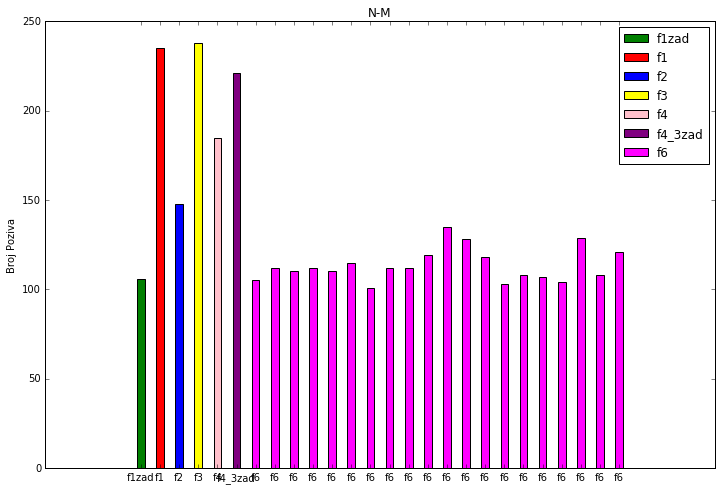

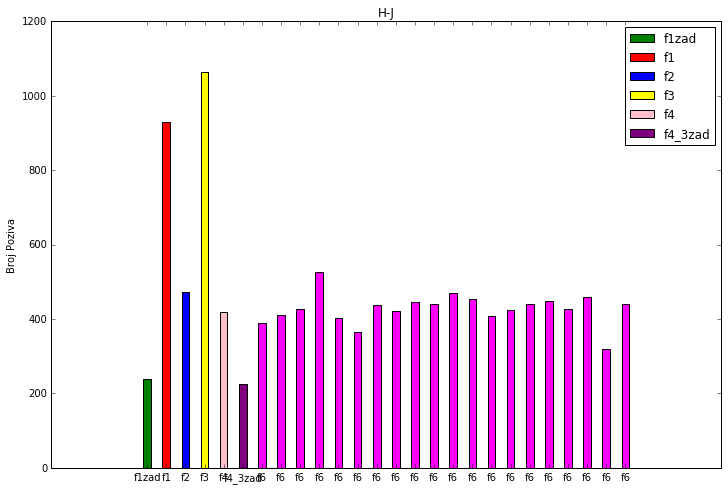

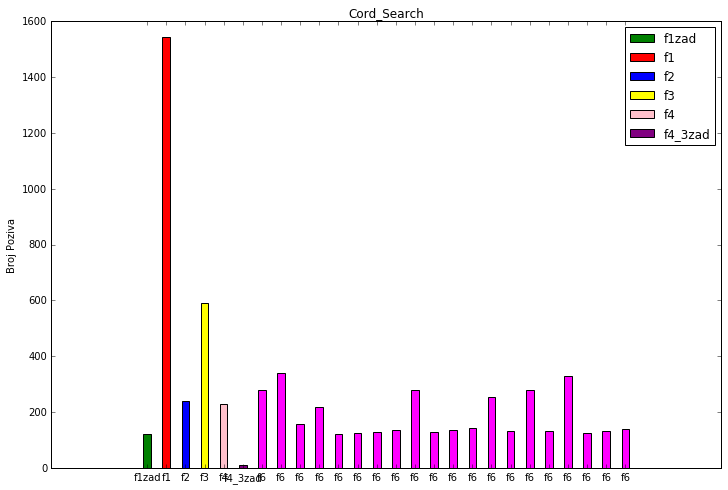

____f1zad____ starting point: [10.0]
N-M f_value: 0.0 rezultat: [ 4.]
H-J f_value: 2.7386188302e-13 rezultat: [ 4.00000052]
Cord_Search f_value: 3.88888094092e-14 rezultat: [3.999999802797542]


____f1____ starting point: [-1.9, 2]
N-M f_value: 3.39555454326e-19 rezultat: [ 1.  1.]
H-J f_value: 2.36352869577e-10 rezultat: [ 1.00000271  1.0000039 ]
Cord_Search f_value: 5.66646112429 rezultat: [-1.3804329699200177, 1.9055954085682372]


____f2____ starting point: [0.1, 0.3]
N-M f_value: 5.94366223544e-19 rezultat: [ 4.  2.]
H-J f_value: 4.82113409128e-10 rezultat: [ 4.00001269  1.99999104]
Cord_Search f_value: 1.20031086512e-12 rezultat: [3.999999910071634, 1.9999994540550041]


____f3____ starting point: [0.0, 0.0, 0.0, 0.0, 0.0]
N-M f_value: 8.0550479486e-08 rezultat: [ 1.00020568  1.99999536  2.99987477  4.0001086   4.99989632]
H-J f_value: 2.07918136829e-10 rezultat: [ 1.          2.          2.99998558  4.          5.        ]
Cord_Search f_value: 5.30018981976e-13 rezultat: [0.9999

In [38]:
num_random = 20
f6_start = []
for i in range(num_random):
    f6_start.append([np.random.uniform(-50,50),np.random.uniform(-50,50)])
functions = [f_test,f1,f2,f3,f4,f4] + [f6]*num_random
fun_names = ["f1zad","f1","f2","f3","f4","f4_3zad"] + ["f6"] * num_random
colors = ["green", "red", "blue", "yellow", "pink", "purple"] + ["magenta"] * num_random
opt_names = ["N-M", "H-J","Cord_Search"]
opt_fun = [nelder_mead,hooke_jeeves,coordinate_search]
starting_points=[[10.],[-1.9,2],[0.1,0.3],[0.,0.,0.,0.,0.],[5.1,1.1],[5,5]]+f6_start
hooke_jeeves
opt_num_calls = []
results = {}
for name in opt_names:
    opt_num_calls.append([0]*len(functions))
    results[name] = {}

for i, fun in enumerate(functions):
    for j,opt in enumerate(opt_fun):
        Fun = Function(fun)
        rez = opt(Fun,starting_points[i])
        results[opt_names[j]][i] = rez
        opt_num_calls[j][i] = Fun.calls

f6_set_flag = False
for i, fname in enumerate(opt_names):
    plt.figure(figsize=(12,8))
    for j,func_name in enumerate(fun_names):
        if func_name == "f6":
            if f6_set_flag == True:
                plt.bar(j, opt_num_calls[i][j], width=0.4, color=colors[j], align="center")
                continue
            else:
                f6_set_flag = True
        plt.bar(j, opt_num_calls[i][j], width=0.4, color=colors[j], align="center", label= fun_names[j])
        
    plt.xticks(range(len(functions)), fun_names, rotation='horizontal')
    plt.title(opt_names[i])
    plt.legend(loc="best")
    plt.ylabel("Broj Poziva")
    plt.show()
    
best_f6_row = None
best_value = None
for i,func_name in enumerate(fun_names):
    flag = False
    row = "____"+func_name + "____"+" starting point: " + str(starting_points[i]) + '\n'
    for j, opt_name in enumerate(opt_names):
        
        row += opt_name + " f_value: " + str(functions[i](results[opt_name][i])) + " rezultat: " + str(results[opt_name][i]) +'\n'
        if (best_value == None or best_value > abs(functions[i](results[opt_name][i]))) and func_name == "f6":
            best_value = abs(functions[i](results[opt_name][i]))
            flag = True
    if func_name == "f6" and flag:
        best_f6_row = row
        continue
    elif func_name == "f6":
        continue
    print row
    print
    
print "Best result for f6"
print best_f6_row
    

# Funkcija f4

In [39]:
x = np.linspace(-10,10,num=100)
x, y = np.meshgrid(x, x)
grid = np.stack((x.flatten(), y.flatten())).transpose()
points = list(grid)
z1 = np.array(map(f4,points))
z1 = z1.reshape(x.shape)

py.iplot([dict(x=x,y=y,z=z1, type='surface')])

# Funkcija f6

In [40]:
x = np.linspace(-10,10,num=100)
x, y = np.meshgrid(x, x)
grid = np.stack((x.flatten(), y.flatten())).transpose()
points = list(grid)
z1 = np.array(map(f6,points))
z1 = z1.reshape(x.shape)

py.iplot([dict(x=x,y=y,z=z1, type='surface')])